In [ ]:
# !pip -qq install torchutils

In [ ]:
# !unzip /content/EuroSAT1.zip -d EuroSAT

In [ ]:
import os
import shutil
import pandas as pd

project_dir = "project"  # Папка, где будут train/ и valid/
source_dir = "/content/EuroSAT"  # Где сейчас лежат изображения
csv_files = {
    "train": "/content/EuroSAT/train.csv",
    "valid": "/content/EuroSAT/validation.csv",
    "test": "/content/EuroSAT/test.csv"
}

for split in ["train", "valid", "test"]:
    df = pd.read_csv(csv_files[split])  # Читаем CSV
    split_dir = os.path.join(project_dir, split)  # train/ или valid/

    for _, row in df.iterrows():
        filename = row["Filename"]
        classname = row["ClassName"]

        # Создаём папку для класса, если её нет
        class_dir = os.path.join(split_dir, classname)
        os.makedirs(class_dir, exist_ok=True)

        # Полные пути
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(class_dir, os.path.basename(filename))

        # Копируем файл
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Файл не найден: {src_path}")

print("Копирование завершено!")


Копирование завершено!


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

import time
import copy
import random

from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights

import pickle

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# делаем словарь, чтобы по индексу найти название класса
labels = json.load(open('/content/EuroSAT/label_map.json'))
# функция декодировки
# Создаем словарь, где ключи - индексы (в виде строк), а значения - названия классов
index_to_label = {str(v): k for k, v in labels.items()}

# Функция декодировки (ищет название класса по индексу)
decode = lambda x: index_to_label[str(x)]

In [ ]:
decode(0)

'AnnualCrop'

In [ ]:
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64,)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((64,)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# подготовим функцию resize для картинок
resize = transforms.Resize((64, 64))

In [ ]:
img = resize(io.read_image('/content/project/test/Forest/Forest_1023.jpg')/255)

In [ ]:
img.shape

torch.Size([3, 64, 64])

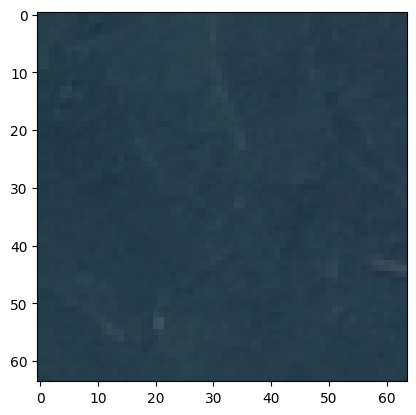

In [ ]:
plt.imshow(torch.permute(img, (1, 2, 0)));

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/project/train', train_transforms)
valid_dataset = torchvision.datasets.ImageFolder('/content/project/valid', val_transforms)

In [ ]:
train_dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
test_batch = next(iter(valid_loader))
single_batch = test_batch[0][0]
single_batch.shape

torch.Size([3, 64, 64])

In [ ]:
# # Конечно, это можно сделать и с помощью оформления класса
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()

        # подгружаем модель
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        # заменяем слой
        self.model.fc = nn.LazyLinear(10)

        # замораживаем слои
        for i in self.model.parameters():
            i.requires_grad = False

        # размораживаем только последний, который будем обучать
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [ ]:
model = MyResNet()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [ ]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def fit(model, n_epochs):
  train_losses = []
  valid_losses = []
  train_acc = []
  valid_acc = []
  for epoch in range(n_epochs):
    model.train()
    train_loss_itter = []
    train_metric_itter = []

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      predict = model(images)
      loss = criterion(predict, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_itter.append(loss.item())
      train_metric_itter.append((predict.argmax(axis=1) == labels).cpu().numpy().mean())


    train_losses.append(np.mean(train_loss_itter))
    train_acc.append(np.mean(train_metric_itter))

    model.eval()
    valid_loss_itter = []
    valid_metric_itter = []
    with torch.no_grad():
      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        predict = model(images)
        loss = criterion(predict, labels)

        valid_loss_itter.append(loss.item())
        valid_metric_itter.append((predict.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())

    valid_losses.append(np.mean(valid_loss_itter))
    valid_acc.append(np.mean(valid_metric_itter))
    print(
    f'Epoch {epoch+1}/{n_epochs}: '
    f'train_loss = {train_losses[-1]:.4f}, train_metric = {train_acc[-1]:.4f} | '
    f'valid_loss = {valid_losses[-1]:.4f}, valid_metric = {valid_acc[-1]:.4f}'
)


  return train_losses, valid_losses, train_acc, valid_acc

In [ ]:
train_losses, valid_losses, train_acc, valid_acc = fit(model, 8)

Epoch 1/8: train_loss = 0.9975, train_metric = 0.7417 | valid_loss = 0.5997, valid_metric = 0.8425
Epoch 2/8: train_loss = 0.5371, train_metric = 0.8541 | valid_loss = 0.4937, valid_metric = 0.8659
Epoch 3/8: train_loss = 0.4444, train_metric = 0.8735 | valid_loss = 0.4397, valid_metric = 0.8699
Epoch 4/8: train_loss = 0.3883, train_metric = 0.8842 | valid_loss = 0.4046, valid_metric = 0.8772
Epoch 5/8: train_loss = 0.3611, train_metric = 0.8906 | valid_loss = 0.4073, valid_metric = 0.8801
Epoch 6/8: train_loss = 0.3335, train_metric = 0.9017 | valid_loss = 0.3931, valid_metric = 0.8759
Epoch 7/8: train_loss = 0.3080, train_metric = 0.9061 | valid_loss = 0.3866, valid_metric = 0.8772
Epoch 8/8: train_loss = 0.2950, train_metric = 0.9102 | valid_loss = 0.3808, valid_metric = 0.8732


In [ ]:
resize = transforms.Resize((64, 64))

In [ ]:
# '/content/project/test/River/River_10.jpg'
# /content/project/test/PermanentCrop/PermanentCrop_1006.jpg
# /content/project/test/Pasture/Pasture_1095.jpg
# /content/project/test/PermanentCrop/PermanentCrop_1168.jpg
# /content/project/test/Forest/Forest_1469.jpg
# /content/project/test/PermanentCrop/PermanentCrop_117.jpg <=

In [ ]:
img = resize(io.read_image('/content/project/test/PermanentCrop/PermanentCrop_117.jpg')/255)

In [ ]:
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

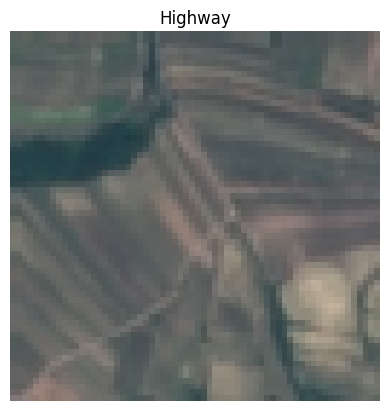

In [ ]:
# model.to(DEVICE)
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.axis('off')
with torch.inference_mode():
    plt.title(class_names[model(img.to(device).unsqueeze(0)).argmax().item()]);

In [ ]:
# Зададим функцию для отрисовки графиков

def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[0].set_ylim((0, max(tl+vl)+.1))

    ax[1].plot(tm, label='Train accuracy')
    ax[1].plot(vm, label='Valid accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    ax[1].set_ylim((0, max(tm+vm)+.1))

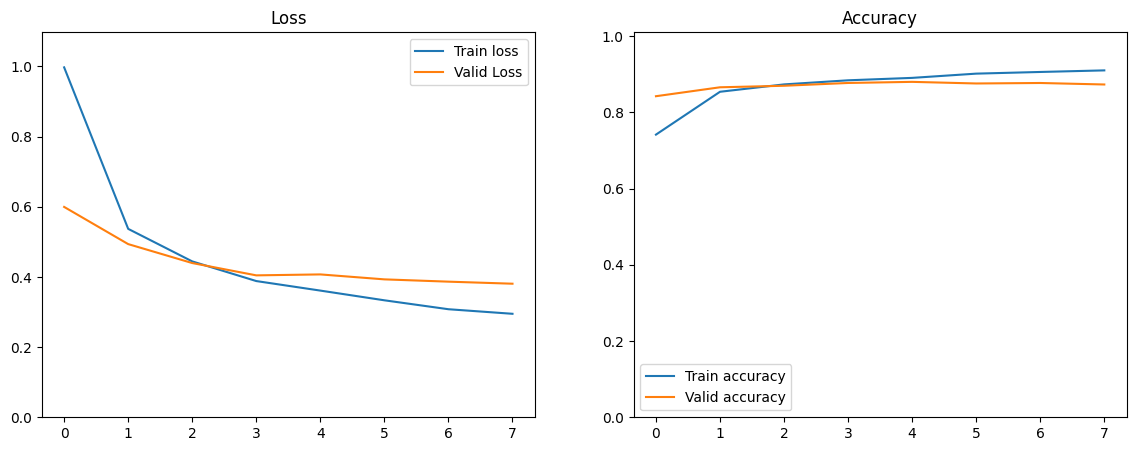

In [ ]:
plot_loss_metrics(train_losses, valid_losses, train_acc, valid_acc)

In [ ]:
# Сохраняем модель в файл model.pkl
# with open('model_resnet50_1.pkl', 'wb') as file:
#     pickle.dump(model, file)

In [ ]:
# torch.save(model.state_dict(), 'weights_model_resnet50_1.pt')